In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
from tensorflow.keras import layers
import time
from IPython import display
from  tqdm import tqdm
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


**Hyper Parameters**

In [2]:
IMAGE_DIMENSIONS  = [32,32,3]
BUFFER_SIZE       = 60000
BATCH_SIZE        = 128
NUM_OF_GENERATORS = 5
LEARNING_RATE     = 1e-5
EPOCHS            = 5000
NOISE_DIM         = 256
NOISE_MEAN        = 0.0
NOISE_STD_DEV     = 0.5
WEIGHT_STD_DEV    = 0.02
VISUALIZE_COUNT   = 16
SEED              = tf.random.normal([VISUALIZE_COUNT,NOISE_DIM],NOISE_MEAN,NOISE_STD_DEV)


**Set Directory**

In [3]:
if not os.path.exists('./{}_G/'.format(NUM_OF_GENERATORS)):
            os.makedirs('./{}_G/'.format(NUM_OF_GENERATORS))


**Load Training Data**

In [4]:
dir_data      = "data/img_align_celeba/"
Ntrain        = 200000 
Ntest        = 100 
nm_imgs       = np.sort(os.listdir(dir_data))
nm_imgs_train = nm_imgs[:Ntrain]
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (IMAGE_DIMENSIONS[0],IMAGE_DIMENSIONS[1],IMAGE_DIMENSIONS[2])

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(dir_data + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(Ntrain).batch(BATCH_SIZE)

X_train.shape = (15243, 32, 32, 3)


**Generator Model**


In [5]:
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512,use_bias = False, input_shape=(NOISE_DIM,), kernel_initializer='random_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Reshape((4,4,512)))
    
    model.add(layers.Conv2DTranspose(256,(5,5),strides=(2,2),use_bias=False,padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=WEIGHT_STD_DEV)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding='same', kernel_initializer=keras.initializers.RandomNormal(stddev=WEIGHT_STD_DEV)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding='same',activation='tanh', kernel_initializer=keras.initializers.RandomNormal(stddev=WEIGHT_STD_DEV)))
    model.summary()
    return model
    

**Test Generator**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              2097152   
_________________________________________________________________
batch_normalization_v2 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


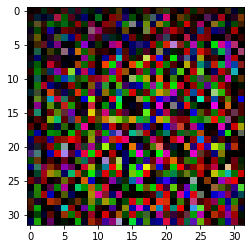

In [6]:
test_generator = Generator() 
noise  = np.random.normal(0,5,(VISUALIZE_COUNT,NOISE_DIM))
generator_output = test_generator(noise,training=False)
plt.imshow(np.squeeze(generator_output[0]))

**Discriminator Model**

In [7]:
def Discriminator():
    noise = layers.GaussianNoise(0.05,input_shape=(IMAGE_DIMENSIONS[0],IMAGE_DIMENSIONS[1],IMAGE_DIMENSIONS[2]))
    noise.trainable = False
    model = tf.keras.Sequential()
    model.add(noise)
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(IMAGE_DIMENSIONS[0],IMAGE_DIMENSIONS[1],IMAGE_DIMENSIONS[2]), kernel_initializer=keras.initializers.RandomNormal(stddev=WEIGHT_STD_DEV))) 
    
    model.add(layers.LeakyReLU(0.02))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same',input_shape=IMAGE_DIMENSIONS, kernel_initializer=keras.initializers.RandomNormal(stddev=WEIGHT_STD_DEV)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.02))

    
    model.add(layers.Flatten())
    model.add(layers.Dense(NUM_OF_GENERATORS+1, kernel_initializer=keras.initializers.RandomNormal(stddev=WEIGHT_STD_DEV),activation='sigmoid'))
    model.summary()
    return model
    

**Test Discriminator**

In [8]:

test_discriminator = Discriminator() 



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

**Define Loss Functions**

In [9]:
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def generatorLoss(fake_prediction):
    dirac_delta = np.zeros(fake_prediction.shape)
    dirac_delta[:,NUM_OF_GENERATORS] = 0.999
    dirac_delta = tf.convert_to_tensor(dirac_delta)
    return cross_entropy_loss(dirac_delta,fake_prediction)


def discriminatorLoss(fake_prediction,real_prediction,generator_index):
    real_dirac_delta = np.zeros(real_prediction.shape)
    real_dirac_delta[:,NUM_OF_GENERATORS] = 0.999
    real_dirac_delta = tf.convert_to_tensor(real_dirac_delta)
    
    fake_dirac_delta = np.zeros(fake_prediction.shape)
    fake_dirac_delta[:,generator_index] = 0.999
    fake_dirac_delta = tf.convert_to_tensor(fake_dirac_delta)
    
    total_loss =cross_entropy_loss(fake_dirac_delta,fake_prediction)+ cross_entropy_loss(real_dirac_delta,real_prediction) 
    return total_loss

**Define Optimizers**

In [10]:
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

generator_optimizer=[None]*NUM_OF_GENERATORS
for i in range(0,NUM_OF_GENERATORS):
    generator_optimizer[i]=tf.keras.optimizers.Adam(LEARNING_RATE)


**Define Model Instances**

In [11]:
discriminator = Discriminator()

generator=[None]*NUM_OF_GENERATORS
for i in range(0,NUM_OF_GENERATORS):
    generator[i]=Generator()
    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8192)              2097152   
_________________________________________________________________
batch_normalization_v2_17 (B (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_v2_18 (B (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 8, 8, 256)        

**Define Checkpoints**

**Define Training**

In [12]:
def generate_noise():
    return tf.random.normal((BATCH_SIZE,NOISE_DIM),NOISE_MEAN,NOISE_STD_DEV)

def training_step(real_image):
    input_noise = generate_noise()
    for i in range(0,NUM_OF_GENERATORS):
        with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape :
            fake_image  = generator[i](input_noise,training=True)

            real_output = discriminator(real_image,training=True)
            fake_output = discriminator(fake_image,training=True)
            
            generator_loss     = generatorLoss(fake_output)
            discriminator_loss = discriminatorLoss(fake_output,real_output,i)

        generator_gradient     = generator_tape.gradient(generator_loss,generator[i].trainable_variables) 
        discriminator_gradient = discriminator_tape.gradient(discriminator_loss,discriminator.trainable_variables) 
        
        generator_optimizer[i].apply_gradients(zip(generator_gradient,generator[i].trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradient,discriminator.trainable_variables))

def train_model(no_of_epochs,data):
    for epoch in range(0,no_of_epochs):
        
        dataset = tqdm(data)
        for image_batch in dataset :
            dataset.set_description(' Epoch %s '%(epoch+1))
            training_step(image_batch)
        
        generate_visualization(epoch)


**Visualization**

In [13]:

def generate_concatenated(image_path_list,filename):
    imgs    = [ PIL.Image.open(i) for i in image_path_list ]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    imgs_comb.save('./{}_G/Result/{}.png'.format(NUM_OF_GENERATORS,filename))
    
def generate_visualization(epoch):
    imgs = []
    for i in range(0,NUM_OF_GENERATORS):
        display.clear_output(wait=True)
        fig = plt.figure(figsize=(4,4))
        generator_output = generator[i](SEED,training = False)
        for j in range(generator_output.shape[0]):
            plt.subplot(4, 4, j+1)
            plt.imshow(generator_output[j, :, :, :] )
            plt.axis('off')
            
        if not os.path.exists('./{}_G/{}/'.format(NUM_OF_GENERATORS,i+1)):
            os.makedirs('./{}_G/{}/'.format(NUM_OF_GENERATORS,i+1))
            
        plt.savefig('./{}_G/{}/{:04d}.png'.format(NUM_OF_GENERATORS,i+1,epoch))
        imgs.append('./{}_G/{}/{:04d}.png'.format(NUM_OF_GENERATORS,i+1,epoch))
    
      
    if not os.path.exists('./{}_G/Result/'.format(NUM_OF_GENERATORS)):
        os.makedirs('./{}_G/Result/'.format(NUM_OF_GENERATORS))
    
    generate_concatenated(imgs,epoch+1)

In [ ]:
train_model(EPOCHS,train_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [ ]:
generate_visualization(-1)

In [ ]:
train_model(EPOCHS,train_dataset)